In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from particle_detection.data.data_pipeline import create_dataloaders

In [2]:
z1 = torch.load('../saved_models/patch1.pt')
z2 = torch.load('../saved_models/patch2.pt')
labels = torch.load('../saved_models/labels.pt')

In [3]:
print(f"z1 shape: {z1.shape}")  # Expected: (N, latent_dim)
print(f"z2 shape: {z2.shape}")  # Expected: (N, latent_dim)
print(f"labels shape: {labels.shape}")  # Expected: (N,)

z1 shape: torch.Size([3418, 1, 16, 16])
z2 shape: torch.Size([3418, 1, 16, 16])
labels shape: torch.Size([3418])


In [4]:
print(labels)

tensor([0., 0., 0.,  ..., 1., 1., 1.])


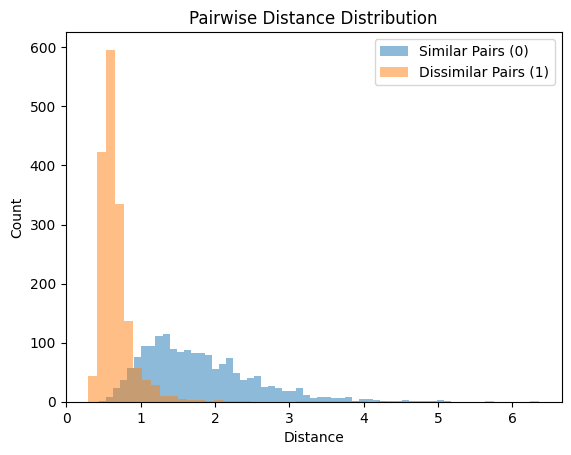

In [5]:
# Reshape z1 and z2 to (N, -1) before computing distances
z1_flat = z1.view(z1.size(0), -1)
z2_flat = z2.view(z2.size(0), -1)

# Now compute the distances
distances = F.pairwise_distance(z1_flat, z2_flat).cpu().numpy()

# Plot histograms for similar (label=0) and dissimilar (label=1) pairs
plt.hist(distances[labels == 0], bins=50, alpha=0.5, label="Similar Pairs (0)")
plt.hist(distances[labels == 1], bins=50, alpha=0.5, label="Dissimilar Pairs (1)")
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Pairwise Distance Distribution")
plt.show()


In [ ]:
z_all = torch.cat([z1, z2], dim=0).cpu().numpy()
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_all)

plt.scatter(z_pca[: len(z1), 0], z_pca[: len(z1), 1], c=labels.cpu().numpy(), cmap="coolwarm", alpha=0.6)
plt.colorbar(label="Similarity Label (0 = Similar, 1 = Dissimilar)")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.title("PCA Projection of Latent Representations")
plt.show()

In [ ]:
nbrs = NearestNeighbors(n_neighbors=5, metric="euclidean").fit(z1.cpu().numpy())
distances, indices = nbrs.kneighbors(z1.cpu().numpy())

print("Nearest Neighbors for first 5 samples:")
for i in range(5):
    print(f"Sample {i} Neighbors: {indices[i]}")
    print(f"Distances: {distances[i]}")

In [ ]:
from sklearn.utils import resample

# Assume z1, z2, and labels are all torch tensors
similar_idx = labels == 0
dissimilar_idx = labels == 1

# Convert to numpy or index tensors
similar_z1 = z1[similar_idx]
similar_z2 = z2[similar_idx]
similar_labels = labels[similar_idx]

dissimilar_z1 = z1[dissimilar_idx]
dissimilar_z2 = z2[dissimilar_idx]
dissimilar_labels = labels[dissimilar_idx]

# Downsample dissimilar pairs
n_similar = len(similar_labels)
dissimilar_z1, dissimilar_z2, dissimilar_labels = resample(
    dissimilar_z1, dissimilar_z2, dissimilar_labels, n_samples=n_similar, replace=False
)

# Combine and shuffle
z1 = torch.cat([similar_z1, dissimilar_z1], dim=0)
z2 = torch.cat([similar_z2, dissimilar_z2], dim=0)
labels = torch.cat([similar_labels, dissimilar_labels], dim=0)

In [ ]:
print(z1.shape)

In [ ]:
torch.save(z1, "../saved_models/patch1.pt")
torch.save(z2, "../saved_models/patch2.pt")
torch.save(labels, "../saved_models/labels.pt")